<a href="https://colab.research.google.com/github/kanopf/Infidelity_detection/blob/main/infidality_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=5ddcb918a122e0dbc37e7f0ce4e4241a7e24896c7730b32b5d77f66c8fa0b5fc
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [21]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [5]:
#Loading theDataset with this head:
#https://www.kaggle.com/datasets/utkarshx27/fairs-extramarital-affairs-data

dataset = pd.read_csv('/content/Affairs.csv')

In [6]:
dataset

,Unnamed: 0,affairs,gender,age,yearsmarried,children,religiousness,education,occupation,rating
0,4,0,male,37.0,10.00,no,3,18,7,4
1,5,0,female,27.0,4.00,no,4,14,6,4
2,11,0,female,32.0,15.00,yes,1,12,1,4
3,16,0,male,57.0,15.00,yes,5,18,6,5
4,23,0,male,22.0,0.75,no,2,17,6,3
...,...,...,...,...,...,...,...,...,...,...
596,1938,1,male,22.0,1.50,yes,1,12,2,5
597,1941,7,female,32.0,10.00,yes,2,18,5,4
598,1954,2,male,32.0,10.00,yes,2,17,6,5
599,1959,2,male,22.0,7.00,yes,3,18,6,2


In [7]:
#Dummie criator for classes

def Dummie_creator(dataset_name, collum_name_loop,collum_name_after, condition_1, condition_2):
  list_collum_to_add = []
  for i in dataset_name['{}'.format(collum_name_loop)]:
    if i == '{}'.format(condition_1):
      value_dummie = 1
    if i == '{}'.format(condition_2):
      value_dummie = 0
    list_collum_to_add.append(value_dummie)
  dataset_name['{}'.format(collum_name_after)] = list_collum_to_add




#that is what is happening in the Dummie_creator function
'''

list_children = []
for i in dataset['children']:
  if i == 'yes':
    value_dummie = 1
  if i == 'no':
    value_dummie = 0
  list_children.append(value_dummie)
dataset['children_dummie'] = list_children

list_gender = []
for i in dataset['gender']:
  if i == 'male':
    value_dummie = 1
  if i == 'female':
    value_dummie = 0
  list_gender.append(value_dummie)
dataset['gender_dummie'] = list_gender

'''


"\n\nlist_children = []\nfor i in dataset['children']:\n  if i == 'yes':\n    value_dummie = 1\n  if i == 'no':\n    value_dummie = 0\n  list_children.append(value_dummie)\ndataset['children_dummie'] = list_children\n\nlist_gender = []\nfor i in dataset['gender']:\n  if i == 'male':\n    value_dummie = 1\n  if i == 'female':\n    value_dummie = 0\n  list_gender.append(value_dummie)\ndataset['gender_dummie'] = list_gender\n\n"

In [8]:
#this dummies is because we need binary variables to train the model

#create children_dummie
Dummie_creator(dataset, 'children', 'children_dummie', 'yes', 'no')

#create gender_dummie
Dummie_creator(dataset,'gender', 'gender_dummie', 'male', 'female')

In [9]:
dataset

,Unnamed: 0,affairs,gender,age,yearsmarried,children,religiousness,education,occupation,rating,children_dummie,gender_dummie
0,4,0,male,37.0,10.00,no,3,18,7,4,0,1
1,5,0,female,27.0,4.00,no,4,14,6,4,0,0
2,11,0,female,32.0,15.00,yes,1,12,1,4,1,0
3,16,0,male,57.0,15.00,yes,5,18,6,5,1,1
4,23,0,male,22.0,0.75,no,2,17,6,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
596,1938,1,male,22.0,1.50,yes,1,12,2,5,1,1
597,1941,7,female,32.0,10.00,yes,2,18,5,4,1,0
598,1954,2,male,32.0,10.00,yes,2,17,6,5,1,1
599,1959,2,male,22.0,7.00,yes,3,18,6,2,1,1


In [10]:
#
#this is why the objective of the project is to determine if with these 
#characteristics he can cheat or not, so lets check in the "affairs" column, 
#if the person cheated, that is affairs > 1 then he receives a dummy with a value of 1, 
#otherwise he receives a dummy with value 0

list_afairrs = []
for i in dataset['affairs']:
  if i > 0:
    value_dummie = 1
  if i == 0:
    value_dummie = 0
  list_afairrs.append(value_dummie)
dataset['infidelity_dummie'] = list_afairrs


In [11]:
dataset

,Unnamed: 0,affairs,gender,age,yearsmarried,children,religiousness,education,occupation,rating,children_dummie,gender_dummie,infidelity_dummie
0,4,0,male,37.0,10.00,no,3,18,7,4,0,1,0
1,5,0,female,27.0,4.00,no,4,14,6,4,0,0,0
2,11,0,female,32.0,15.00,yes,1,12,1,4,1,0,0
3,16,0,male,57.0,15.00,yes,5,18,6,5,1,1,0
4,23,0,male,22.0,0.75,no,2,17,6,3,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,1938,1,male,22.0,1.50,yes,1,12,2,5,1,1,1
597,1941,7,female,32.0,10.00,yes,2,18,5,4,1,0,1
598,1954,2,male,32.0,10.00,yes,2,17,6,5,1,1,1
599,1959,2,male,22.0,7.00,yes,3,18,6,2,1,1,1


+------+-----+
|gender|count|
+------+-----+
|female|  315|
|  male|  286|
+------+-----+



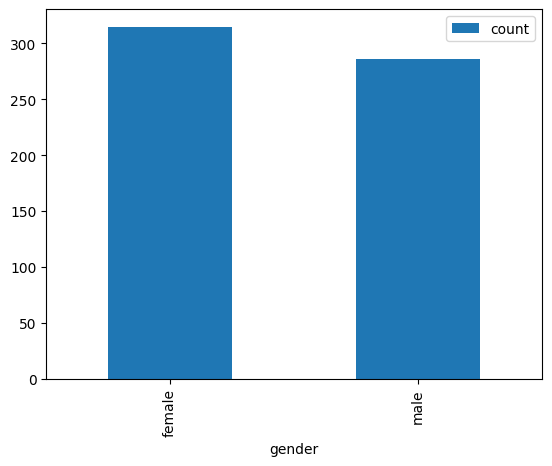

In [20]:
#let's make some exploration in the data using now pyspark (for exercise)

# what is the distribuition of gender in this data
spark = SparkSession.builder.getOrCreate()
df_explore = spark.createDataFrame(dataset)
count_gender = df_explore.groupBy('gender').count()
count_gender.show()
count_df = count_gender.toPandas()
count_df.plot(kind='bar', x='gender', y='count')

plt.show()

#here we can see the gender distribuitions

+------+-----+
|gender|count|
+------+-----+
|female|   57|
|  male|   59|
+------+-----+



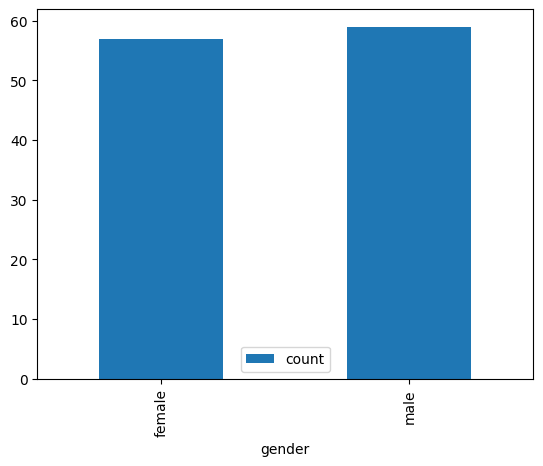

The persentage of male unfaith in data is 20.62937062937063%
The persentage of female unfaith in data is 18.095238095238095%


In [28]:
#now we can see the number of betrayals by gender and also the number of men and women who were unfaithful at least once

count_affairs_by_gender = df_explore.filter(col('affairs') > 1).groupBy('gender').count()

# Exibição do resultado
count_affairs_by_gender.show()

count_df_2 = count_affairs_by_gender.toPandas()
count_df_2.plot(kind='bar', x='gender', y='count')

plt.show()

#now we have:

total_male = 286
total_female = 315

male_unfaith = 59
female_unfaith = 57

persentage_male_unfaith = male_unfaith/total_male *100
persentage_female_unfaith = female_unfaith/total_female *100

print('The persentage of male unfaith in data is {}%'.format(persentage_male_unfaith))
print('The persentage of female unfaith in data is {}%'.format(persentage_female_unfaith))



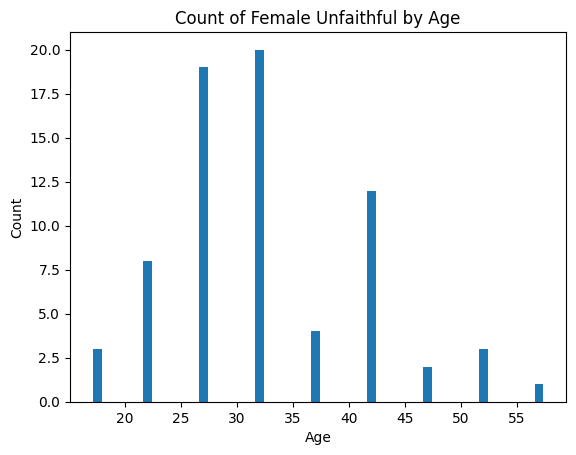

In [32]:
#here we can see the age distribuition from unfaith female


female_unfaith = df_explore.filter((df_explore['gender'] == 'female') & (df_explore['affairs'] > 0)).select('age')


count_df = female_unfaith.groupBy('age').count()


count_data = count_df.collect()


age_values = [row['age'] for row in count_data]
count_values = [row['count'] for row in count_data]


plt.bar(age_values, count_values)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Count of Female Unfaithful by Age')
plt.show()

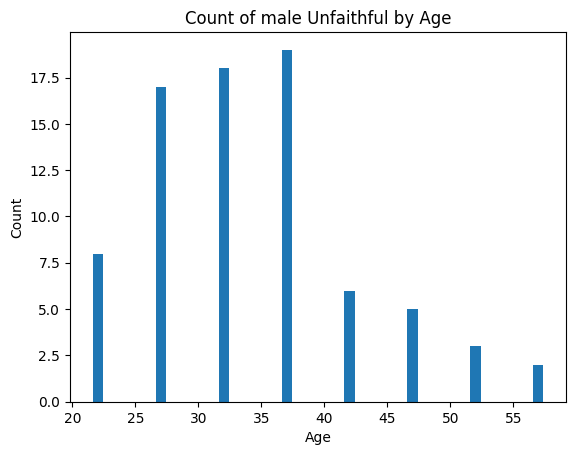

In [33]:
#here we can see the age distribuition from unfaith male

male_unfaith = df_explore.filter((df_explore['gender'] == 'male') & (df_explore['affairs'] > 0)).select('age')


count_df = male_unfaith.groupBy('age').count()


count_data = count_df.collect()


age_values = [row['age'] for row in count_data]
count_values = [row['count'] for row in count_data]


plt.bar(age_values, count_values)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Count of male Unfaithful by Age')
plt.show()

In [ ]:
#Drop this colluns, we won't use this

dataset = dataset.drop('affairs', axis=1)
dataset = dataset.drop('children', axis=1)
dataset = dataset.drop('gender', axis=1)

In [ ]:
dataset

,Unnamed: 0,age,yearsmarried,religiousness,education,occupation,rating,children_dummie,gender_dummie,infidelity_dummie
0,4,37.0,10.00,3,18,7,4,0,1,0
1,5,27.0,4.00,4,14,6,4,0,0,0
2,11,32.0,15.00,1,12,1,4,1,0,0
3,16,57.0,15.00,5,18,6,5,1,1,0
4,23,22.0,0.75,2,17,6,3,0,1,0
...,...,...,...,...,...,...,...,...,...,...
596,1938,22.0,1.50,1,12,2,5,1,1,1
597,1941,32.0,10.00,2,18,5,4,1,0,1
598,1954,32.0,10.00,2,17,6,5,1,1,1
599,1959,22.0,7.00,3,18,6,2,1,1,1


In [ ]:
#here we can check how much values have in this 2 classes

(dataset['infidelity_dummie']).value_counts()



0    451
1    150
Name: infidelity_dummie, dtype: int64

In [ ]:
#now we need to take only 150 values of 0 class (faithful person)

df_variavel_0 = dataset[dataset['infidelity_dummie'] == 0].sample(n=150)


df_variavel_1 = dataset[dataset['infidelity_dummie'] == 1]


df_filtered = pd.concat([df_variavel_0, df_variavel_1])

In [ ]:
(df_filtered['infidelity_dummie']).value_counts()

0    150
1    150
Name: infidelity_dummie, dtype: int64

In [ ]:
df_filtered

,Unnamed: 0,age,yearsmarried,religiousness,education,occupation,rating,children_dummie,gender_dummie,infidelity_dummie
99,508,37.0,15.0,4,20,6,5,1,1,0
424,1861,27.0,7.0,2,20,5,4,1,1,0
179,854,37.0,15.0,4,14,5,4,1,0,0
81,413,57.0,15.0,4,20,6,5,1,1,0
367,1584,37.0,10.0,4,16,1,5,1,0,0
...,...,...,...,...,...,...,...,...,...,...
596,1938,22.0,1.5,1,12,2,5,1,1,1
597,1941,32.0,10.0,2,18,5,4,1,0,1
598,1954,32.0,10.0,2,17,6,5,1,1,1
599,1959,22.0,7.0,3,18,6,2,1,1,1


In [ ]:
#Now take 80% of values to train and 20% for validation

df_0 = df_filtered[df_filtered['infidelity_dummie'] == 0].sample(frac=0.8)
df_1 = df_filtered[df_filtered['infidelity_dummie'] == 1].sample(frac=0.8)

df_test = pd.concat([df_filtered[df_filtered['infidelity_dummie'] == 0].drop(df_0.index),
                          df_filtered[df_filtered['infidelity_dummie'] == 1].drop(df_1.index)])
df_test = df_test.drop('Unnamed: 0', axis=1)

df_train = pd.concat([df_0,df_1])
df_train = df_train.drop('Unnamed: 0', axis=1)

In [ ]:
df_train

,age,yearsmarried,religiousness,education,occupation,rating,children_dummie,gender_dummie,infidelity_dummie
167,22.0,1.5,4,14,5,4,0,0,0
354,27.0,4.0,4,12,1,5,1,0,0
19,27.0,10.0,2,14,1,5,1,0,0
428,32.0,15.0,5,16,5,3,1,0,0
143,52.0,15.0,2,18,5,4,1,1,0
...,...,...,...,...,...,...,...,...,...
590,27.0,7.0,4,16,1,2,1,0,1
591,42.0,15.0,3,18,6,2,1,1,1
555,37.0,15.0,5,17,5,2,1,1,1
520,52.0,15.0,3,14,4,4,1,0,1


In [ ]:
# here we take the variables to trrain and the target variation

df_train_for_train = df_train[['age','yearsmarried','religiousness','education','occupation','rating','children_dummie','gender_dummie']]

df_train_target = df_train[['infidelity_dummie']]


In [ ]:
df_train_for_train.shape[1]

8

In [ ]:
df_test_input = df_test[['age','yearsmarried','religiousness','education','occupation','rating','children_dummie','gender_dummie']]
df_test_real_output = df_test[['infidelity_dummie']]

In [ ]:
# Defining the model
model = keras.Sequential([
    keras.layers.Dense(64, input_dim=df_train_for_train.shape[1], activation='tanh'),
    keras.layers.Dense(64, activation='tanh'),
    keras.layers.Dense(1, activation='sigmoid')

])

model.compile(optimizer="adam", loss='binary_crossentropy')


history = model.fit(df_train_for_train, df_train_target, epochs=4000, verbose = 1)


A saída de streaming foi truncada nas últimas 5000 linhas.
8/8 [==============================] - 0s 3ms/step - loss: 0.0282
Epoch 1502/4000
8/8 [==============================] - 0s 4ms/step - loss: 0.0295
Epoch 1503/4000
8/8 [==============================] - 0s 5ms/step - loss: 0.0277
Epoch 1504/4000
8/8 [==============================] - 0s 3ms/step - loss: 0.0231
Epoch 1505/4000
8/8 [==============================] - 0s 4ms/step - loss: 0.0227
Epoch 1506/4000
8/8 [==============================] - 0s 3ms/step - loss: 0.0226
Epoch 1507/4000
8/8 [==============================] - 0s 3ms/step - loss: 0.0209
Epoch 1508/4000
8/8 [==============================] - 0s 3ms/step - loss: 0.0217
Epoch 1509/4000
8/8 [==============================] - 0s 3ms/step - loss: 0.0275
Epoch 1510/4000
8/8 [==============================] - 0s 3ms/step - loss: 0.0306
Epoch 1511/4000
8/8 [==============================] - 0s 4ms/step - loss: 0.0289
Epoch 1512/4000
8/8 [==============================] - 

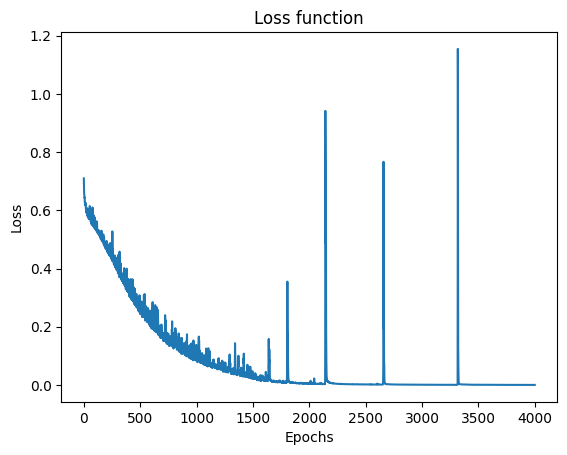

In [ ]:
# Plot the loss function
plt.plot(history.history['loss'])
plt.title('Loss function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:

#here we make a predictions for test set, if the prediction have more of 50% of 
#precision in the output of Softmax we use unfaithful class 

predictions_in_test = []
for index, row in df_test_input.iterrows():
    #print(row)
    sample = row.values  
    sample = sample.reshape(1, -1)  
    prediction = model.predict(sample)  
    prediction = [1 if pred > 0.5 else 0 for pred in prediction]
    predictions_in_test.append(prediction[0])  

1/1 [==============================] - 0s 23ms/step


In [ ]:
#here we make a predictions for train set, if the prediction have more of 50% of 
#precision in the output of Softmax we use unfaithful class 

predictions_in_train = []
for index, row in df_train_for_train.iterrows():
    #print(row)
    sample = row.values  # Converter a linha em um array
    sample = sample.reshape(1, -1)  # Reshape para adequar às dimensões de entrada do modelo
    prediction = model.predict(sample)  # Fazer a previsão para a linha
    prediction = [1 if pred > 0.5 else 0 for pred in prediction]
    predictions_in_train.append(prediction[0])  # Armazenar a previsão

1/1 [==============================] - 0s 25ms/step


In [ ]:
#predictions in test set
predictions_in_tested = pd.DataFrame(predictions_in_test)
predictions_in_tested.columns = ['infidelity_dummie_tested']

#predictions in train set
predictions_in_trained = pd.DataFrame(predictions_in_train)
predictions_in_trained.columns = ['infidelity_dummie_trained']

In [ ]:
#df_train_target

df_train_real_output = df_train_target.reset_index(drop=True)

#df_test_target

df_test_real_output = df_test_real_output.reset_index(drop=True)

In [ ]:
#comparition with test real
comparition_test = df_test_real_output['infidelity_dummie'] == predictions_in_tested['infidelity_dummie_tested']

#comparition with train real
comparition_train = df_train_real_output['infidelity_dummie'] == predictions_in_trained['infidelity_dummie_trained']

In [ ]:
comparition_test.value_counts()

#here we have 78,3% of precision in the detection in the test set

True     47
False    13
dtype: int64

In [ ]:
#here we have 100% of precision in the detection in the test set

comparition_train.value_counts()

True    240
dtype: int64